In [2]:
# -- imports
%matplotlib inline
import numpy as np
import os
import pandas as pd
from config import *
import glob
from astropy.io import fits
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

In [3]:
ffpath = os.path.join(configs["dpath"], "autoscan_features.3.feather") #this .feather file contain only the ID and OBJECT_TYPE for the images that I have on my computer
new_labels = pd.read_feather(ffpath)

# dropping ALL duplicte values 
new_labels.drop_duplicates(inplace=True) 
new_labels = new_labels.sort_values(by=['ID'])
new_labels = new_labels.reset_index(drop = True)
  
# displaying data 
new_labels

,ID,OBJECT_TYPE,AMP,A_IMAGE,A_REF,BAND,B_IMAGE,B_REF,CCDID,COLMEDS,...,N3SIG3,N3SIG3SHIFT,N3SIG5,N3SIG5SHIFT,NN_DIST_RENORM,NUMNEGRN,SCALE,SNR,SPREADERR_MODEL,SPREAD_MODEL
0,75605,1,0.917655,1.242,3.060010,g,0.944,2.439935,21,0.120526,...,0,-9,0,-9,0.235493,24,1.381313,6.526832,0.005189,-0.009116
1,75898,1,0.179013,0.935,2.576239,g,0.922,1.820171,18,0.032853,...,0,-12,0,-14,0.257563,23,1.692956,5.573217,0.006101,-0.004171
2,76051,1,0.013268,1.528,3.647787,g,1.233,3.159317,57,0.267664,...,0,-10,0,-20,0.941432,5,0.260088,13.978503,0.002139,-0.003000
3,76229,1,0.569777,0.834,5.210605,g,0.685,5.056543,5,0.072407,...,0,-22,0,-46,0.219160,14,1.852880,5.592828,0.006952,-0.000032
4,76392,1,0.524820,1.094,1.924387,g,0.525,1.850099,45,0.085889,...,0,-14,0,-16,0.333854,25,1.650108,4.965725,0.007083,-0.010008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898958,11874751,0,0.975729,1.520,1.802727,z,1.252,1.150422,10,0.110625,...,0,6,0,6,0.275255,14,1.969859,9.565697,0.003626,0.010192
898959,11874758,0,0.776830,0.750,2.405035,z,0.676,1.279556,10,0.128664,...,0,1,0,1,1.101463,15,1.244608,5.641251,0.006096,-0.008210
898960,11874762,0,0.455947,0.802,5.320844,z,0.500,2.230924,10,0.095031,...,0,-10,0,-14,0.938816,24,1.674698,4.633825,0.007645,0.001634
898961,11874772,0,0.764371,1.494,2.043744,z,1.267,1.958380,10,0.075626,...,0,0,0,0,0.734137,22,1.793416,11.305648,0.003113,0.003695


In [4]:
#Create path for diff, srch, temp images
pttype = '*'

srch1 = os.path.join(configs["dpath"],'Stamps1','20130829', '*',pttype + '*.fits') #general path of the images 
srch2 = os.path.join(configs["dpath"],'Stamps1','20130831', '*',pttype + '*.fits')
srch3 = os.path.join(configs["dpath"],'Stamps1','20130901', '*',pttype + '*.fits')
flist1  = np.array(sorted(glob.glob(srch1))) #recorre el path por *, recorre temp, srch y diff y el *.fits por el numero de la imagen
flist2  = np.array(sorted(glob.glob(srch2)))
flist3  = np.array(sorted(glob.glob(srch3)))
flist = np.concatenate((flist1,flist2,flist3))


In [5]:
len(flist)

8061

In [6]:
#Extract the ID of the flist
ID =[int(f.split('/')[-1][4:-5]) for f in flist]
ID [:9]

[6962491,
 6962491,
 6962491,
 6963820,
 6963820,
 6963820,
 6969123,
 6969133,
 6969123]

In [7]:
#extract from .feather file the ID that are on flist
current_labels = new_labels[new_labels["ID"].isin(ID)]
current_labels = current_labels[["ID", "OBJECT_TYPE"]]
current_labels = current_labels.sort_values(by= ["ID"]).reset_index(drop=True)
current_labels

,ID,OBJECT_TYPE
0,6960252,1
1,6961062,1
2,6961064,1
3,6961300,1
4,6961308,0
...,...,...
2682,7778614,0
2683,7778883,1
2684,7779002,1
2685,7779022,1


In [8]:
#counts for 0 type and 1 type
counts_type = np.unique(current_labels['OBJECT_TYPE'], return_counts=True)
print("0 = {} and 1 = {}".format(counts_type[1][0], counts_type[1][1]))

0 = 790 and 1 = 1897


In [9]:
imlist_dict = {}

# stores the name of the images as a list for ID above
#is a circle because i extract the ID for the flist, buttt
imlist_dict['flist'] = [f for f in flist if int(f.split('/')[-1][4:-5]) in current_labels["ID"].to_numpy()]
print (len(imlist_dict['flist']))


#N = imlist_dict["nimgs"] = int(imlist_dict["fnumbers"].shape[0]) 
imlist_dict["imshp"] = fits.open((imlist_dict["flist"][0]))[0].data.shape #shape row,col
extension="fits"
imdtype = {"fits":float, "gif":np.uint8, }

8061


In [10]:
#sort as: descending ID and diff, srch, temp
imlist_dict["flist"] = sorted(imlist_dict["flist"], key=lambda s: s.split('/')[-1][:4])
imlist_dict["flist"]= sorted(imlist_dict["flist"], key=lambda s: s.split('/')[-1][4:])
imlist_dict["flist"][:9]

['/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130829/470681007/diff6960252.fits',
 '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130829/470681007/srch6960252.fits',
 '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130829/470681007/temp6960252.fits',
 '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130829/470681006/diff6961062.fits',
 '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130829/470681006/srch6961062.fits',
 '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130829/470681006/temp6961062.fits',
 '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130829/470681006/diff6961064.fits',
 '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130829/470681006/srch6961064.fits',
 '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130829/470681006/temp6961064.fits']

In [11]:
imlist_dict["flist"][-9:]

['/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130901/472216022/diff7779002.fits',
 '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130901/472216022/srch7779002.fits',
 '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130901/472216022/temp7779002.fits',
 '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130901/472216022/diff7779022.fits',
 '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130901/472216022/srch7779022.fits',
 '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130901/472216022/temp7779022.fits',
 '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130901/472313664/diff7779140.fits',
 '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130901/472313664/srch7779140.fits',
 '/Users/tatianaacerocuellar/Documents/Delaware/Data/Stamps1/20130901/472313664/temp7779140.fits']

In [12]:
#container for data train and data test
data_full = np.zeros((len(imlist_dict["flist"]),imlist_dict["imshp"][0], imlist_dict["imshp"][1]),imdtype[extension])

#fill the container and open images
for i in range(len(imlist_dict["flist"])):
    data_full[i] = fits.open(''.join(imlist_dict["flist"][i]))[0].data


In [13]:
data_full.shape

(8061, 51, 51)

In [14]:
#convert float for normalize
data_norm = data_full.astype(float)

In [15]:
# --normalize
# mean and std for diff images
# min and max for srch and temp

data_norm[::3] = (data_norm[::3]- data_norm[::3].mean(axis=(1,2), keepdims=True))/data_norm[::3].std(axis=(1,2), keepdims=True) #diff
    
data_norm[1::3]= (data_norm[1::3]-data_norm[1::3].min(axis=(1,2), keepdims=True))/data_norm[1::3].max(axis=(1,2), keepdims=True) #srch
data_norm[2::3]= (data_norm[2::3]-data_norm[2::3].min(axis=(1,2), keepdims=True))/data_norm[2::3].max(axis=(1,2), keepdims=True) #temp

In [16]:
#concatenate diff srch temp for the same ID

final_data = np.zeros((int(len(data_full)//3),imlist_dict["imshp"][0], imlist_dict["imshp"][1]*3))
final_data = np.concatenate((data_norm[::3],data_norm[1::3],data_norm[2::3]), axis = 2)


In [17]:
print('Final lenght of data = {}'.format(final_data.shape)) 

Final lenght of data = (2687, 51, 153)


In [18]:
#exxtract the objects  = 0
df_ID_0 = current_labels[current_labels["OBJECT_TYPE"]==0]
#df_ID_0

In [19]:
#exxtract the objects  = 1
df_ID_1 = current_labels[current_labels["OBJECT_TYPE"]==1]
#df_ID_1

In [20]:
#the len is the minimun of object 0, and object 1. To have equal data of both
len_each_set = min(len(df_ID_0), len(df_ID_1))
len_each_set

790

In [21]:
#extract random the number of data classify as 0
index_data_ID0 = df_ID_0.sample(len_each_set-10, random_state = 2).sort_index()
len(index_data_ID0)

780

In [22]:
#extract random the number of data classify as 1
index_data_ID1 = df_ID_1.sample(len_each_set+10,random_state = 2).sort_index()
len(index_data_ID1)

800

In [23]:
#convert index to numpy to iterate
index_ID0 = index_data_ID0.index.to_numpy()
index_ID0[:9]

array([ 4,  7,  9, 13, 14, 15, 16, 17, 24])

In [24]:
#convert index to numpy to iterate
index_ID1 = index_data_ID1.index.to_numpy()
index_ID1[:9]

array([ 2,  3,  5, 10, 22, 23, 26, 28, 31])

In [25]:
#concatenate both index
indexes = sorted(np.concatenate((index_ID0, index_ID1)))
indexes[:10]

[2, 3, 4, 5, 7, 9, 10, 13, 14, 15]

In [26]:
#extract the data from the index given above, of the complete data, where 0 and 1 are not equal
equal_type_data = len(indexes)
print("Len of data where len(ID_0) = len(ID_1) = {}".format(equal_type_data))

Len of data where len(ID_0) = len(ID_1) = 1580


In [27]:
#70% is for training
#30% testing
train_len = int(equal_type_data*0.7)
test_len = equal_type_data  - int(equal_type_data*0.7)
print('Final lenght of train = {}, Final lenght of test = {} '.format(train_len, test_len))

Final lenght of train = 1106, Final lenght of test = 474 


In [28]:
import random
random.seed(4)
random_index = random.sample(range(0, equal_type_data), train_len)
random_index[:10]

[483, 621, 211, 1477, 811, 980, 317, 184, 136, 40]

In [29]:
#70% is for training
#30% testing
train = np.array([final_data[i] for i in [indexes[i] for i in sorted(random_index)]])
test = np.array([final_data[i] for i in indexes if i not in [indexes[i] for i in sorted(random_index)]])
len(train),len(test)

(1106, 474)

In [30]:
#extracting the label 0 or 1
targets = [current_labels.iloc[i]["OBJECT_TYPE"] for i in indexes]
targets[:10]

[1, 1, 0, 1, 0, 0, 1, 0, 0, 0]

In [31]:
#split the targets
train_targ = np.array([current_labels.iloc[i]["OBJECT_TYPE"] for i in [indexes[i] for i in sorted(random_index)]])
test_targ = np.array([current_labels.iloc[i]["OBJECT_TYPE"] for i in indexes if i not in [indexes[i] for i in sorted(random_index)]])
len(train_targ),len(test_targ)

(1106, 474)

In [32]:
(unique, counts) = np.unique(test_targ, return_counts=True)
(unique, counts)

(array([0, 1]), array([225, 249]))

In [33]:
(unique, counts) = np.unique(train_targ, return_counts=True)
(unique, counts)

(array([0, 1]), array([555, 551]))

In [34]:
#extract the ID0
ID0 = index_data_ID0["ID"].to_numpy()
ID0[:9]

array([6961308, 6961351, 6961845, 6961954, 6961958, 6962011, 6962027,
       6962037, 6962376])

In [35]:
#extract the ID1
ID1 = index_data_ID1["ID"].to_numpy()
ID1[:9]

array([6961064, 6961300, 6961332, 6961933, 6962158, 6962225, 6962414,
       6962438, 6962536])

In [36]:
#concatenate the ID that are going to be used here
IDs = sorted(np.concatenate((ID0, ID1)))
IDs[:10]

[6961064,
 6961300,
 6961308,
 6961332,
 6961351,
 6961845,
 6961933,
 6961954,
 6961958,
 6962011]

In [37]:
flist[1].split('/')[-1][4:-5]

'6962491'

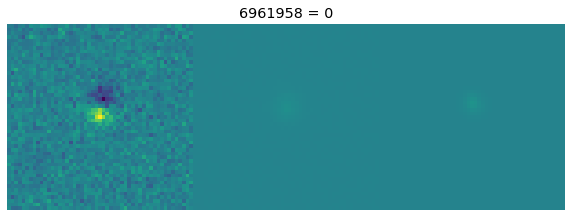

In [38]:
plt.style.use("bmh")

plt.figure(figsize=(10, 10))
#fig, ax = plt.subplots()
plt.axis("off")
plt.imshow(train[0])
plt.title("{} = {}".format(IDs[8], train_targ[8]))
plt.show()


In [39]:
np.random.seed(1)
tf.random.set_seed(346)

# -- define the network
layer1 = keras.layers.Conv2D(16, kernel_size=(5, 5), padding="valid", activation="relu", input_shape=(51, 153, 1))
layer2 = keras.layers.MaxPooling2D((2, 2), strides=2)
layer3 = keras.layers.Conv2D(32, kernel_size=(5, 5), padding="valid", activation="relu", input_shape=(51, 153, 1))
layer4 = keras.layers.MaxPooling2D((2, 2), strides=2)
layer5 = keras.layers.Flatten()
#layer6 = keras.layers.Dropout(0.4)
layer7 = keras.layers.Dense(32, activation="relu")
layer8 = keras.layers.Dense(2, activation="softmax")
layers = [layer1, layer2, layer3, layer4, layer5, layer7,layer8]

# -- instantiate the convolutional neural network
model = keras.Sequential(layers)

opt = keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# -- feautres need to have an extra axis on the end (for mini-batching)
feat_tr2 = train.reshape(len(train), 51, 153, 1)
feat_te2 = test.reshape(len(test), 51, 153, 1)

# -- fit the model
history = model.fit(feat_tr2, train_targ, validation_split=0.20, epochs=40, batch_size=20)

# -- print the accuracy
loss_tr, acc_tr = model.evaluate(feat_tr2, train_targ)
loss_te, acc_te = model.evaluate(feat_te2, test_targ)

print("Training accuracy : {0:.4f}".format(acc_tr))
print("Testing accuracy  : {0:.4f}".format(acc_te))

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")




Train on 884 samples, validate on 222 samples
Epoch 1/40
884/884 [==============================] - 29s 32ms/sample - loss: 0.4057 - accuracy: 0.8631 - val_loss: 0.3361 - val_accuracy: 0.9324
Epoch 2/40
884/884 [==============================] - 24s 27ms/sample - loss: 0.2831 - accuracy: 0.9072 - val_loss: 0.2638 - val_accuracy: 0.9009
Epoch 3/40
884/884 [==============================] - 26s 29ms/sample - loss: 0.2342 - accuracy: 0.9118 - val_loss: 0.4988 - val_accuracy: 0.7477
Epoch 4/40
884/884 [==============================] - 27s 31ms/sample - loss: 0.2291 - accuracy: 0.9005 - val_loss: 0.1945 - val_accuracy: 0.9369
Epoch 5/40
884/884 [==============================] - 26s 30ms/sample - loss: 0.1815 - accuracy: 0.9321 - val_loss: 0.5134 - val_accuracy: 0.7387
Epoch 6/40
884/884 [==============================] - 26s 29ms/sample - loss: 0.1716 - accuracy: 0.9321 - val_loss: 0.1907 - val_accuracy: 0.9459
Epoch 7/40
884/884 [==============================] - 25s 28ms/sample - loss: 

474/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Training accuracy : 0.9892
Testing accuracy  : 0.9726
Saved model to disk


In [40]:
#keys of the model
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [41]:
loss_te

0.11173088779429344

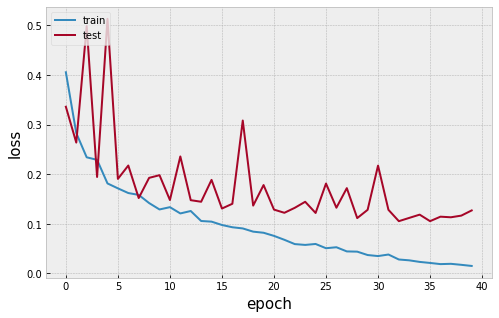

In [42]:
# -- plot the loss function
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train", "test"], loc="upper left")
ax.set_xlabel("epoch", fontsize=15)
ax.set_ylabel("loss", fontsize=15)
plt.savefig("loss.pdf",bbox_inches="tight")
#fig.show()

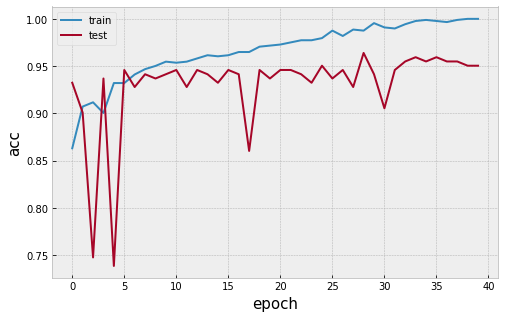

In [43]:
# -- plot the accuracy function
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["train", "test"], loc="upper left")
ax.set_xlabel("epoch", fontsize=15)
ax.set_ylabel("acc", fontsize=15)
plt.savefig("acc.pdf",bbox_inches="tight")
#fig.show()

In [44]:
#confusion matrix for test data
y_pred = model.predict(feat_te2)
con_mat = tf.math.confusion_matrix(labels=test_targ, predictions=np.argmax(y_pred,axis=1)).numpy()
con_mat

array([[219,   6],
       [  7, 242]], dtype=int32)

In [71]:
con_mat.flatten()

array([219,   6,   7, 242], dtype=int32)

In [45]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
 
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = [0,1], 
                     columns = [0,1])
con_mat_df
#How do I know what is the order: 0,1 or 1,0??

,0,1
0,0.97,0.03
1,0.03,0.97


In [72]:
con_mat_norm.flatten()

array([0.97, 0.03, 0.03, 0.97])

In [86]:
labels = [f"{v1}\n{v2*100}%" for v1, v2 in
          zip(con_mat.flatten(),con_mat_norm.flatten())]
#labels = np.asarray(labels).reshape(2,2)
labels = np.asarray(labels).reshape(2,2)

In [95]:
categories = ["0: Real", "1: Bogus"]

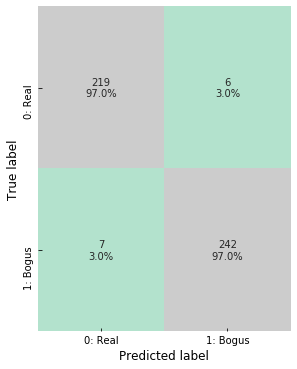

In [97]:

figure = plt.figure(figsize=(4, 5))
sns.heatmap(con_mat, annot=labels,cbar=False,fmt='',xticklabels=categories,yticklabels=categories,cmap='Pastel2')#plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("confusionmatrixinitmodel.pdf",bbox_inches="tight")
plt.show()

In [ ]:
Colormap Palette is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r